# Прогнозирование цен на гостиничные номера в центре Чикаго

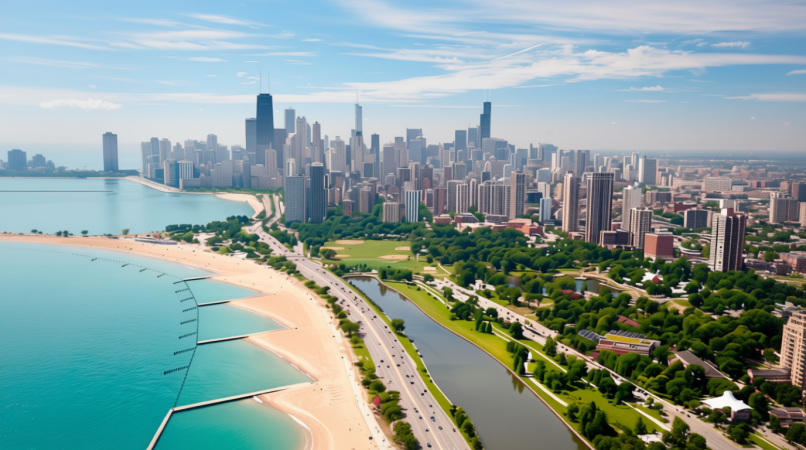

`Общее описание данных` ([источник](http://www.choosechicago.com/))

Данные представляют собой ежемесячную статистику по гостиницам в центральном деловом районе Чикаго (Chicago Central Business District Hotel Statistics) за период с 1994 по 2003 год.

Набор данных включает временные метки и ключевой показатель $-$ среднюю стоимость номера (Average Daily Rate, **ADR**) в долларах США, рассчитанную как среднее значение цены за номер в день по всем отелям и всем дням каждого месяца.
<br><br>
`Необходимо` использовать **LinearRegression** для прогноза ADR на **6 месяцев** вперёд:

In [ ]:
forecast_horizon = 6

# Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

# Загрузка данных

In [ ]:
data = pd.read_csv('Chicago_hotels.csv')

In [ ]:
data[:3]

date1  date2     adr
0   January   1994  104.04
1  February   1994  102.74
2     March   1994  105.23

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date1   112 non-null    object 
 1   date2   112 non-null    int64  
 2   adr     112 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


Описательные статистики:

In [ ]:
data.describe().round(2)

date2     adr
count   112.00  112.00
mean   1998.18  143.84
std       2.71   22.48
min    1994.00  102.74
25%    1996.00  126.37
50%    1998.00  142.76
75%    2000.25  162.38
max    2003.00  190.71

Уникальные значения в столбце `date1`:

In [ ]:
data.date1.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

Создадим единый столбец с датой, отсортируем данные по нему и удалим исходные столбцы с датами:

In [ ]:
data['date'] = pd.to_datetime(
    data.date2.astype(str) + '-' + data.date1,
    format='%Y-%B'
).dt.to_period('M')

data = data.sort_values('date').reset_index(drop=True)
data = data.drop(columns=['date1', 'date2'])

In [ ]:
data[:3]

adr     date
0  104.04  1994-01
1  102.74  1994-02
2  105.23  1994-03

# Предсказание ADR

In [ ]:
# Выборка для подгонки
X_train = data[:-forecast_horizon].copy()
X_train = X_train.drop(columns=['adr'])
Y_train = data[:-forecast_horizon].adr.copy()

# Выборка для предсказания
X_test = data.copy()
X_test = X_test.drop(columns=['adr'])
Y_test = data.adr.copy()

Визуализация распределения и динамики `ADR`:

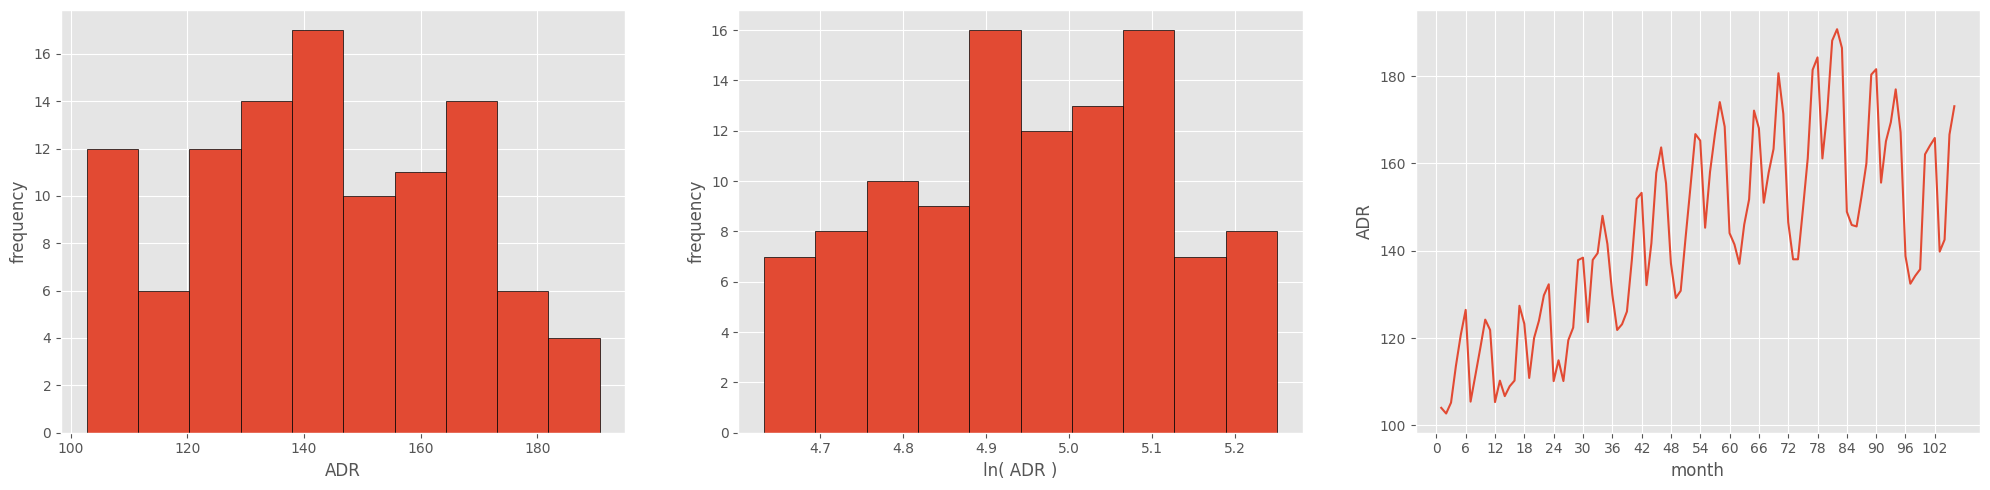

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Левый график: гистограмма
axes[0].hist(Y_train, edgecolor='black')
axes[0].set_xlabel('ADR')
axes[0].set_ylabel('frequency')

# Средний график: ln(гистограмма)
log_vals = np.log(Y_train)
axes[1].hist(log_vals, edgecolor='black')
axes[1].set_xlabel('ln( ADR )')
axes[1].set_ylabel('frequency')

# Правый график: временной ряд
axes[2].plot(
    range(1, len(Y_train) + 1),
    Y_train.values
)
axes[2].set_xlabel('month')
axes[2].set_ylabel('ADR')
tick_positions = np.arange(0, len(Y_train) + 1, 6)
axes[2].set_xticks(tick_positions)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

> Логарифмирование данных, как правило, не ухудшает качество моделирования и может способствовать улучшению его результатов.
> <br><br>
> Временной ряд ADR:
> * Устойчивый рост $-$ от \$100 на старте до пика \$190 к месяцу 84.
> * Ярко выраженная годовая сезонность $-$ пики повторяются каждые 12 месяцев.
> * После месяца 84 наблюдается снижение уровня ADR.

Далее будем использовать модель вида:

$$
\ln(\text{y=ADR}) = \beta_0 + \beta_1 t + \beta_2 t^2 + \sum_{m=1}^{11} \gamma_m \cdot \mathbb{I}(\text{month} = m) + \varepsilon
$$

где

* $t$ $-$ номер месяца от начала наблюдений (линейный тренд),  
* $t^{2}$ $-$ квадрат этого номера (нелинейная компонента тренда),  
* $\mathbb{I}(\text{month} = m)$ $-$ бинарные индикаторы календарных месяцев (сезонность),  
* $\beta_0, \beta_1, \beta_2, \gamma_m$ $-$ оцениваемые коэффициенты,  
* $\varepsilon$ $-$ случайная ошибка.  

Один из месяцев не включается в сумму для избежания мультиколлинеарности.

Поскольку в задании требуется использовать обычную линейную регрессию, а не регуляризованные методы, то стандартизация признаков не окажет влияния на качество предсказаний. Метод наименьших квадратов инвариантен к линейным преобразованиям признаков, поэтому масштабирование будет опущено.

Для оценки качества модели линейной регрессии будем использовать метрику `MAPE` (Mean Absolute Percentage Error).
<br><br>
Подготовим данные:

In [ ]:
# Бинарные индикаторы календарных месяцев
def add_month_dummies(df, date_col='date', drop_month=None):
    df = df.copy()
    if drop_month is not None:
        if not (1 <= drop_month <= 12):
            raise ValueError('drop_month должен быть целым числом от 1 до 12 или None.')

    for month in range(1, 13):
        if drop_month is None or month != drop_month:
            df[f'month_{month}'] = (df[date_col].dt.month == month).astype(int)

    return df

drop_month = 5
X_train = add_month_dummies(df=X_train, drop_month=drop_month)
X_test = add_month_dummies(df=X_test, drop_month=drop_month)


# Остальные преобразования
X_train['month_num'] = range(1, len(X_train) + 1)
X_train['month_num_square'] = X_train.month_num ** 2
X_train = X_train.drop(columns=['date'])
Y_train = np.log(Y_train)

X_test['month_num'] = range(1, len(X_test) + 1)
X_test['month_num_square'] = X_test.month_num ** 2
X_test = X_test.drop(columns=['date'])
Y_test = np.log(Y_test)

Когда мы моделируем **логарифм целевой переменной**

$$
z = \ln y
$$

и обучаем модель линейной регрессии (минимизирующую **MSE**), мы фактически предсказываем **среднее значение логарифма**

$$
\hat{z} = \mathbb{E}[\ln y \mid x].
$$

Но нам нужно предсказать саму переменную $y$ (ADR в долларах США).

---

Следствие **неравенства Йенсена**: для выпуклой функции $\phi$ ($e^x$ $-$ выпуклая) выполняется

$$
\mathbb{E}[\phi(X)] \ge \phi(\mathbb{E}[X])
$$

или

$$
\mathbb{E}[y \mid x] = \mathbb{E}[e^{\ln y} \mid x] \ge e^{\mathbb{E}[\ln y \mid x]} = e^{\hat{z}},
$$

то есть **$e^{\hat{z}}$ систематически занижает среднее значение $y$**.

---

Ошибки в лог-масштабе почти нормальны, то есть

$$
\varepsilon \sim \mathcal{N}(0, \sigma^2),
$$

тогда при фиксированном $x$

$$
\ln y \mid x \sim \mathcal{N}(\mu, \sigma^2).
$$

Следовательно, $y \mid x$ имеет **логнормальное распределение**. Теперь посчитаем его математическое ожидание:

$$
\mathbb{E}[y \mid x] = \mathbb{E}[e^{\ln y} \mid x] = \mathbb{E}[e^{X}].
$$

А математическое ожидание $\mathbb{E}[e^{tX}]$ для нормальной случайной величины $-$ это **момент-производящая функция**:

$$
\mathbb{E}[e^{tX}] = e^{(\mu t + \frac{1}{2} \sigma^2 t^2)}.
$$

Подставляем $t=1$:

$$
\mathbb{E}[e^{X}] = e^{(\mu + \frac{1}{2} \sigma^2)}.
$$

---

Окончательно (практические формулы):

$$
\hat{\sigma}^2 = \frac{1}{n - p} \sum_{i=1}^n (z_i - \hat{z}_i)^2, \quad \hat{y} = e^{(\hat{z} + \frac{1}{2} \hat{\sigma}^2)},
$$

где $p$ $-$ число параметров модели.

---
<br><br>
Выполним `подгонку` модели:

> Следует учитывать наличие **разгонного периода** в начале временного ряда $-$ первые N-месяцев могут характеризоваться нестабильной динамикой, что делает их менее репрезентативными для долгосрочных паттернов. В таких случаях целесообразно исключить начальные наблюдения из обучающей выборки.

Поправка на несмещённость: 0.00047582658534732226



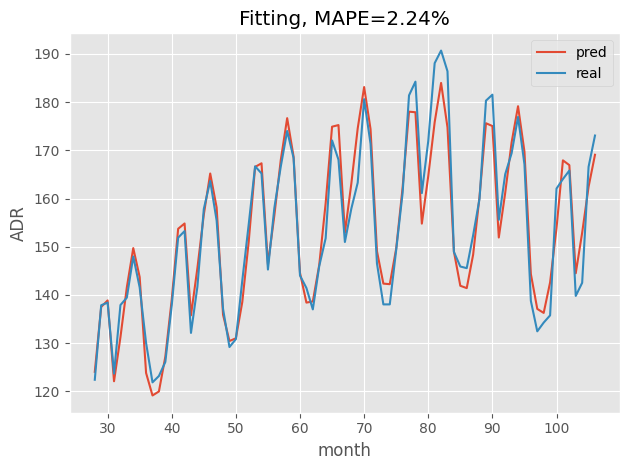

In [ ]:
# Настройка
start_months = 28  # месяц, с которого начинаем учиться
mask = (X_train.month_num >= start_months)
X_subset = X_train[mask]
y_log_true = Y_train[mask].values
y_true = np.exp(y_log_true)

# Обучение и предсказания
model = LinearRegression()
model.fit(X_subset, y_log_true)
y_log_pred = model.predict(X_subset)

# Остатки и дисперсия
residuals = y_log_true - y_log_pred
n = X_subset.shape[0]
p = X_subset.shape[1] + 1
sigma2 = np.sum(residuals**2) / (n - p)
y_pred = np.exp(y_log_pred + 0.5*sigma2)  # предсказания с поправкой
print(f'Поправка на несмещённость: {0.5*sigma2}', end=2*'\n')

# Метрика
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Визуализация
pd.DataFrame({
    'pred': y_pred,
    'real': y_true
}, index=X_subset.month_num).plot()
plt.xlabel('month')
plt.ylabel('ADR')
plt.title(f'Fitting, MAPE={mape:.2f}%')
plt.tight_layout()
plt.show()

> Впрочем, поправка на несмещённость оказалась незначительной (малая дисперсия остатков).


Выполним `предсказание`:

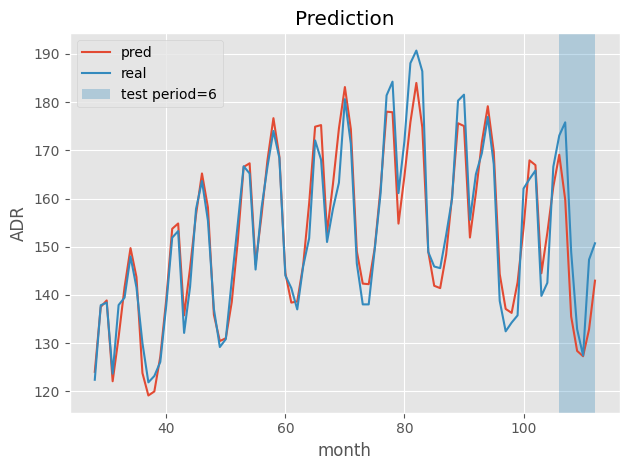

In [ ]:
# Настройка
start_months = 28
mask_train = (X_train.month_num >= start_months)
mask_test = (X_test.month_num >= start_months)

test_subset = X_test[mask_test]
train_subset = X_train[mask_train]
y_train = Y_train[mask_train]
y_true = np.exp(Y_test[mask_test].values)

# Обучение и предсказания
model = LinearRegression()
model.fit(train_subset, y_train)
y_pred = np.exp(model.predict(test_subset) + 0.5*sigma2)

# Визуализация
pd.DataFrame({
    'pred': y_pred,
    'real': y_true
}, index=test_subset.month_num).plot()
plt.xlabel('month')
plt.ylabel('ADR')
plt.title(f'Prediction')

train_end = train_subset.month_num.max()
test_end = test_subset.month_num.max()
plt.axvspan(train_end, test_end, alpha=0.3, label=f'test period={forecast_horizon}')
plt.legend()
plt.tight_layout()
plt.show()